# **WINE CASE: Modeling**

In [20]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
wine_db = sqlite3.connect('wine.db')
cursor = wine_db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('ficha_tecnica',), ('harmonizacao',), ('price',), ('review_rating',), ('sommelier',)]


In [22]:
ficha_df = pd.read_sql_query("SELECT * from ficha_tecnica", wine_db)
ficha_df.head()

,sku,tipo,uva,pais,regiao,vinicola,teor_alcoolico,amadurecimento,classificacao,visual,aroma,gosto,temperatura,potencial_de_guarda
0,10839,Espumante,"Chardonnay, Glera, Pinot Bianco",Itália,Friuli,Fantinel,11.50% ABV,Em tanques de aço inox,Brut,Amarelo-palha com reflexos esverdeados,"Maçã, flores brancas","Leve, fresco, floral, frutado, acidez agradável",8 °C,4 anos
1,11549,Branco,Furmint (100%),Hungria,Tokaj,Pajzos,11.00% ABV,Sem passagem por carvalho.,Suave/Doce,Amarelo dourado,"Frutas brancas maduras, mel, figo seco, frutas...","Doce, equilibrado, acidez agradável, final longo",10 °C,15 anos
2,11610,Espumante,"Chenin Blanc (60%), Chardonnay (40%)",Argentina,Mendoza,Finca La Chamiza,12.00% ABV,1 mês sobre as borras.,Brut,Amarelo,"Frutas amarelas maduras, toque de fermento","Maduro, leve, acidez agradável, delicada cremo...",8 °C,3 anos
3,11982,Licoroso,Nero d'Avola,Itália,Marsala,Cantine Pellegrino,18.00% ABV,Mais de um ano em barricas,Suave/Doce,Rubi com reflexos âmbar.,"Frutas negras em compota, frutas secas, carame...","Levemente adocicado, taninos leves e sabor int...",12 °C,6 anos
4,11983,Licoroso,"Catarratto, Grillo",Itália,Marsala,Cantine Pellegrino,18.00% ABV,4 anos em barris de carvalho.,Suave/Doce,Ouro intenso com reflexos âmbar.,"Frutas cristalizadas, casca de laranja, baunil...","Doce, macio, cheio e persistente.",12 °C,8 anos


## **Data pre-processing**

In [23]:
def OneHotEncoder_to_DataFrame(category_list, index_list):
    
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(category_list)
    label_enconded = label_encoder.inverse_transform(np.arange(len(np.unique(integer_encoded))))
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    category_df = pd.DataFrame(onehot_encoded, index=index_list, columns=label_enconded)
    
    return category_df    

### **Tipos de vinhos**

In [24]:
tipos = ficha_df['tipo'].copy().values
tipos_df = OneHotEncoder_to_DataFrame(tipos, ficha_df.index)
tipos_df.head()

,Branco,Espumante,Frisante,Licoroso,Rosé,Tinto
0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0


### **Tipos de uvas**

In [25]:
def make_uva_df(ficha_df, max_features=20):

    uva_df = pd.DataFrame(index=ficha_df.index)
    uva_df['Uvas'] = pd.Series(np.zeros(len(uva_df.index)))
    uva_df['Nº de uvas'] = pd.Series(np.zeros(len(uva_df.index)))

    import re
    for i in ficha_df.index:
        uvas = ficha_df['uva'][i]
        uva_list = (re.sub(r" ?\([^)]+\)", "", uvas))
        uva_df['Uvas'][i] = uva_list
        uva_df['Nº de uvas'][i] = uva_list.count(',') + 1

    from sklearn.feature_extraction.text import CountVectorizer

    vectorizer = CountVectorizer(lowercase=False, ngram_range=(1,1), max_features=max_features)
    bag_sparse = vectorizer.fit_transform(uva_df['Uvas'])
    bag_of_words = pd.DataFrame.sparse.from_spmatrix(bag_sparse, columns=vectorizer.get_feature_names())

    uva_df.drop(columns='Uvas', inplace=True)
    uva_df = pd.concat([uva_df, bag_of_words], axis=1)
    
    return uva_df

In [26]:
uva_df = make_uva_df(ficha_df)
uva_df.head()

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Nº de uvas,Blanc,Cabernet,Carménère,Chardonnay,Franc,Garnacha,Grenache,Malbec,Merlot,...,Nacional,Noir,Petit,Pinot,Sangiovese,Sauvignon,Syrah,Tempranillo,Touriga,Verdot
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Vinhos por países**

In [27]:
paises = ficha_df['pais'].copy().values
pais_df = OneHotEncoder_to_DataFrame(paises, ficha_df.index)
pais_df.head()

,Alemanha,Argentina,Austrália,Brasil,Chile,China,Espanha,Estados Unidos,França,Hungria,Itália,Nova Zelândia,Portugal,Uruguai,África do Sul
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### **Teor alcoolico**

In [28]:
def make_teor_df(ficha_df):
    
    teor_alcool = []

    for teor_string in ficha_df['teor_alcoolico']:
            teor_alcool.append(teor_string.strip('% ABV'))

    teor_alcool = np.array(teor_alcool, 'float')

    teor_df = pd.DataFrame(index=ficha_df.index)
    teor_df['Teor alcoolico'] = teor_alcool
    
    return teor_df

In [29]:
teor_df = make_teor_df(ficha_df)
teor_df.head()

,Teor alcoolico
0,11.5
1,11.0
2,12.0
3,18.0
4,18.0


### **Temperatura**

In [30]:
def make_temp_df(ficha_df):

    temp = []

    for temp_string in ficha_df['temperatura']:
            temp.append(temp_string.strip(' °C'))

    temp = np.array(temp, 'float')

    temp_df = pd.DataFrame(index=ficha_df.index)
    temp_df['Temperatura'] = temp
    
    return temp_df

In [31]:
temp_df = make_temp_df(ficha_df)
temp_df.head()

,Temperatura
0,8.0
1,10.0
2,8.0
3,12.0
4,12.0


### **Classificação do vinho**

In [32]:
classificacao = ficha_df['classificacao']
class_df = OneHotEncoder_to_DataFrame(classificacao, ficha_df.index)
class_df.head()

,Brut,Extra Brut,Meio Seco/Demi-Sec,Nature,Seco,Suave/Doce
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0


### **Local de amadurecimento**

In [33]:
def make_local_df(ficha_df):
    
    local_df = pd.DataFrame(index=ficha_df.index)
    local_df['Carvalho'] = pd.Series(np.zeros(len(local_df)))
    local_df['Aço inox'] = pd.Series(np.zeros(len(local_df)))
    local_df['Garrafa'] = pd.Series(np.zeros(len(local_df)))
    local_df['Borra'] = pd.Series(np.zeros(len(local_df)))
    local_df['Charmat'] = pd.Series(np.zeros(len(local_df)))

    for i in ficha_df.index:
        local = ficha_df['amadurecimento'][i]
        if (local.find('barrica') > 0) | (local.find('barril') > 0) | (local.find('carvalho') > 0):
            if (local.find('Sem') < 0):
                local_df['Carvalho'][i] = 1
        if local.find('aço inox') > 0 | local.find('tanque') > 0 :
            if (local.find('Sem') < 0):
                local_df['Aço inox'][i] = 1
        if local.find('garrafa') > 0:
            if (local.find('Sem') < 0):
                local_df['Garrafa'][i] = 1
        if local.find('borra') > 0:
            if (local.find('Sem') < 0):
                local_df['Borra'][i] = 1
        if (local.find('charmat')) > 0 | (local.find('Charmat') > 0):
            if local.find('Sem') < 0:
                local_df['Charmat'][i] = 1

    return local_df

In [34]:
local_df = make_local_df(ficha_df)
local_df.head()

,Carvalho,Aço inox,Garrafa,Borra,Charmat
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


## **Modeling**

In [322]:
X_sample = pd.concat(
    [tipos_df, uva_df, pais_df, class_df, local_df, teor_df, temp_df], axis=1)
X_sample.head()

,Branco,Espumante,Frisante,Licoroso,Rosé,Tinto,Nº de uvas,Blanc,Cabernet,Carménère,...,Nature,Seco,Suave/Doce,Carvalho,Aço inox,Garrafa,Borra,Charmat,Teor alcoolico,Temperatura
0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.5,8.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,10.0
2,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,8.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,18.0,12.0
4,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0,0,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,18.0,12.0


In [36]:
pot_anos = []

for pot_string in ficha_df['potencial_de_guarda']:
    if ('ano' not in pot_string):
        print('ERROR: potencial_de_guarda nao esta em anos:')
        print(pot_string)
    else:
        pot_anos.append(pot_string.strip('anos '))
        
pot_anos = np.array(pot_anos, 'int')

In [37]:
Y_sample = pd.DataFrame(index=ficha_df.index)
Y_sample['Potencial de guarda'] = pot_anos
Y_sample.head()

,Potencial de guarda
0,4
1,15
2,3
3,6
4,8


In [38]:
pot_range = [0,5,10,20,50]
Y_sample.groupby(pd.cut(Y_sample['Potencial de guarda'], pot_range)).count()

,Potencial de guarda
Potencial de guarda,
"(0, 5]",510
"(5, 10]",282
"(10, 20]",43
"(20, 50]",18


In [39]:
Y_sample['Potencial bin'] = pd.Series(np.zeros(len(Y_sample)))

for i in range(len(pot_range)-1):
    ii = (Y_sample['Potencial de guarda'] > pot_range[i]) & (Y_sample['Potencial de guarda'] <= pot_range[i+1])
    Y_sample['Potencial bin'][ii] = i
    
Y_sample.head()

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Potencial de guarda,Potencial bin
0,4,0.0
1,15,2.0
2,3,0.0
3,6,1.0
4,8,1.0


### **Amostras de treino e teste**

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X_sample, Y_sample['Potencial bin'], test_size=0.25, stratify=Y_sample['Potencial bin'], random_state=0)

### **Modeling 1: Decision Tree Classifier**

In [41]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(max_depth=4, random_state=0, max_features=None)
model_tree.fit(x_train, y_train)
score = model_tree.score(x_test, y_test)*100
print("The accuracy score from the Decision Tree Classifier model is %.2f%%" % score)

The accuracy score from the Decision Tree Classifier model is 74.77%


### **Modeling 2: Random Forest Classifier**

In [42]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=4, random_state=0, max_features=None)
model_rf.fit(x_train, y_train)
score = model_rf.score(x_test, y_test)*100
print("The accuracy score from the Random Forest Classifier model is %.2f%%" % score)

The accuracy score from the Random Forest Classifier model is 79.44%


### **Modeling 3: Logistic Regression**

In [43]:
from sklearn.linear_model import LogisticRegression
model_lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
model_lg.fit(x_train, y_train)
score = model_lg.score(x_test, y_test)*100
print("The accuracy score from the Logistic Regression model is %.2f%%" % score)

The accuracy score from the Logistic Regression model is 71.50%


/home/anderson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## **Cross validation**

> Nós precisamos tornar a validação mais robusta, i.e., independente das escolhas aleatórias na separação das amostras de treino e teste, e dos próprios modelos preditivos

### **K-Folds cross-validator from SkLearn**

* gera indices para as amostras de treino e teste 
* separa o dataset em consecutivos k folds

In [44]:
def cross_validation(model, X_train, Y_train, n_rep=10, n_splits=4):
    
    from sklearn.model_selection import KFold
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    
    score_model = []

    for i in range(n_rep):
        
        # No stratified kfold
        # kfold = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        
        # Stratified kfold
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=i)

        # print('Random state', i+1)

        j = 0    
        for j_train, j_valid in kfold.split(X_train, Y_train):
            # print('Fold', j+1)
            j =+ 1        

            # print('Size of the train sample:', j_train.shape[0])
            # print('Size of the valid sample:', j_valid.shape[0])

            x_train, x_valid = X_train.iloc[j_train], X_train.iloc[j_valid]
            y_train, y_valid = Y_train.iloc[j_train], Y_train.iloc[j_valid]

            model.fit(x_train, y_train)
            y_pred = model.predict(x_valid)
            score = accuracy_score(y_valid, y_pred)
            score_model.append(score) 
            # print('Score from the model:', score)       

        # print()
        
    return np.array(score_model)

In [45]:
score_tree = cross_validation(model_tree, x_train, y_train, n_rep=50, n_splits=3)
score_rf = cross_validation(model_rf, x_train, y_train, n_rep=50, n_splits=3)
score_lg = cross_validation(model_lg, x_train, y_train, n_rep=50, n_splits=3)

/home/anderson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/anderson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

In [46]:
print("The accuracy scores with from CV")
print("Decision Tree: %.3f +- %.3f" % (score_tree.mean(), score_tree.std()))
print("Random Forest: %.3f +- %.3f" % (score_rf.mean(), score_rf.std()))
print("Logistic Regression: %.3f +- %.3f" % (score_lg.mean(), score_lg.std()))

The accuracy scores with from CV
Decision Tree: 0.697 +- 0.032
Random Forest: 0.726 +- 0.027
Logistic Regression: 0.700 +- 0.026


/home/anderson/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Score')

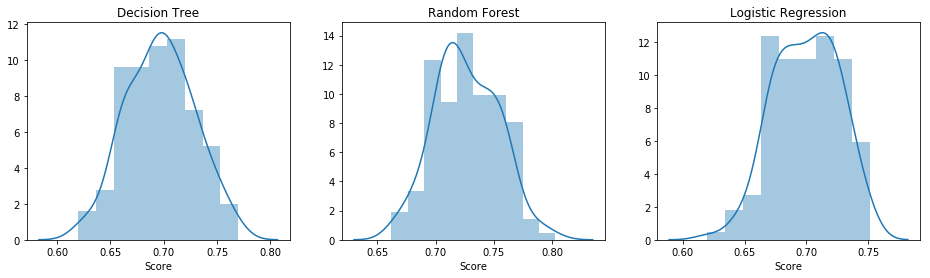

In [47]:
plt.figure(figsize=(16,4))

plt.subplot(131)
sns.distplot(score_tree)
plt.title('Decision Tree')
plt.xlabel('Score')

plt.subplot(132)
sns.distplot(score_rf)
plt.title('Random Forest')
plt.xlabel('Score')

plt.subplot(133)
sns.distplot(score_lg)
plt.title('Logistic Regression')
plt.xlabel('Score')

## **Avaliação do modelo**

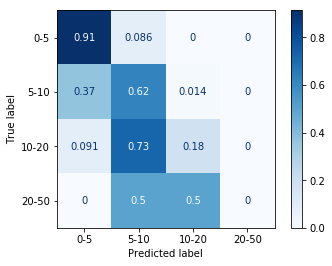

In [48]:
from sklearn.metrics import plot_confusion_matrix
labels_display = ['0-5', '5-10', '10-20', '20-50']
plot_confusion_matrix(model_rf, x_test, y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

> **Overfitting sobre os vinhos de potencial de guarda baixo**
* Baixa precisão para os vinhos de potencial de guarda alto

### **Random Oversampling**
> Popular as classes minoritárias duplicando algumas entradas

* **The most oversampled class**

In [49]:
ii = Y_sample['Potencial de guarda'] <= 5
major_class_id = Y_sample[ii].index
major_class_len = len(major_class_id)

* **Oversampling as outras classes**

In [50]:
ii = (Y_sample['Potencial de guarda'] > 5) & (Y_sample['Potencial de guarda'] <= 10)
minor_class_id = Y_sample[ii].index
random_minor_id = np.random.choice(minor_class_id, major_class_len)
oversample_id = np.concatenate([major_class_id, random_minor_id])

In [51]:
ii = (Y_sample['Potencial de guarda'] > 10) & (Y_sample['Potencial de guarda'] <= 20)
minor_class_id = Y_sample[ii].index
random_minor_id = np.random.choice(minor_class_id, major_class_len)
oversample_id = np.concatenate([oversample_id, random_minor_id])

In [52]:
ii = (Y_sample['Potencial de guarda'] > 20) & (Y_sample['Potencial de guarda'] <= 50)
minor_class_id = Y_sample[ii].index
random_minor_id = np.random.choice(minor_class_id, major_class_len)
oversample_id = np.concatenate([oversample_id, random_minor_id])

* **Os novos oversamples para treino e teste**

In [53]:
X_oversample = X_sample.iloc[oversample_id]
Y_oversample = Y_sample.iloc[oversample_id]

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    X_oversample, Y_oversample['Potencial bin'], test_size=0.25, stratify=Y_oversample['Potencial bin'], random_state=0)

In [55]:
model_rf.fit(x_train, y_train)
score = model_rf.score(x_test, y_test)*100
print("The accuracy score from the Random Forest Classifier model is %.2f%%" % score)

The accuracy score from the Random Forest Classifier model is 72.94%


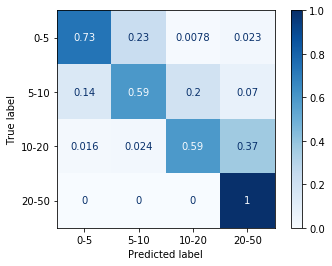

In [56]:
labels_display = ['0-5', '5-10', '10-20', '20-50']
plot_confusion_matrix(model_rf, x_test, y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

* **Overfitting sobre os vinhos de potencial de guarda alto**
* **A técnica de reamostragem deve ser feita somente nos dados de treino**
* **As amostra de teste e validação devem ser consistentes com a amotra original de dados**

### **Synthetic Minority Over-sampling Technique**
> SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
>> Criação de dados sintéticos por interpolação no espaço das features

> Como a técnica SMOTE faz cálculos de distâncias para realizar a interpolação de pontos, deveríamos renormalizar os pontos no espaço das features (StandardScaler). Porém, como muitas features são categóricas e mutuamente excludentes (como tipo, país, e classificação), a técnica de reamostragem tem que considerar isso.

In [427]:
x_train, x_test, y_train, y_test = train_test_split(
    X_sample, Y_sample['Potencial bin'], test_size=0.25, stratify=Y_sample['Potencial bin'], random_state=0)

* **Over-sample using SMOTE for continuous and categorical features**

In [430]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=np.arange(53), 
             sampling_strategy='auto', random_state=0, k_neighbors=12, n_jobs=-1)
x_resample, y_resample = sm.fit_resample(x_train, y_train)

/home/anderson/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/anderson/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/anderson/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


In [432]:
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=12, random_state=0, max_features=None)
model_rf.fit(x_resample, y_resample)

score = model_rf.score(x_test, y_test)*100
print("The accuracy score from the Random Forest Classifier model is %.2f%%" % score)

The accuracy score from the Random Forest Classifier model is 73.83%


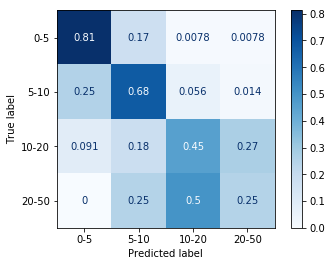

In [433]:
labels_display = ['0-5', '5-10', '10-20', '20-50']
plot_confusion_matrix(model_rf, x_test, y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

**Ainda prevemos mal os vinhos de alto potencial de guarda**

### **Random Over-Sampler**

> Class to perform random over-sampling.
>> Object to over-sample the minority class(es) by picking samples at random with replacement.

In [434]:
x_train, x_test, y_train, y_test = train_test_split(
    X_sample, Y_sample['Potencial bin'], test_size=0.25, stratify=Y_sample['Potencial bin'], random_state=0)

In [446]:
from imblearn.over_sampling import RandomOverSampler
RandOver = RandomOverSampler(sampling_strategy='auto', random_state=0)
x_resample, y_resample = RandOver.fit_resample(x_train, y_train)

In [480]:
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=14, random_state=0, max_features=None)
model_rf.fit(x_resample, y_resample)

score = model_rf.score(x_test, y_test)*100
print("The accuracy score from the Random Forest Classifier model is %.2f%%" % score)

The accuracy score from the Random Forest Classifier model is 76.17%


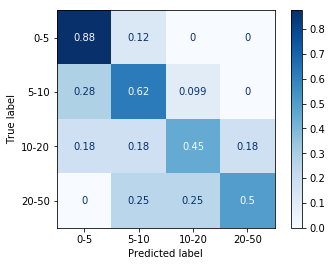

In [481]:
labels_display = ['0-5', '5-10', '10-20', '20-50']
plot_confusion_matrix(model_rf, x_test, y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

## **Decision Tree: visualization**

In [43]:
from sklearn.tree import export_graphviz
import graphviz

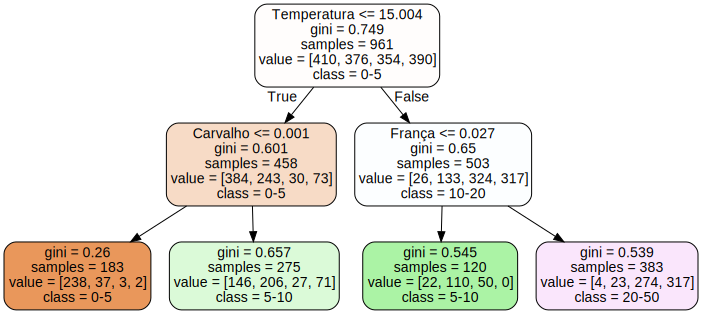

In [44]:
model_rf_test = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, max_depth=2, random_state=0, max_features=None)
model_rf_test.fit(x_train, y_train)

estimator = model_rf_test.estimators_[3]
dot_data = export_graphviz(estimator, out_file=None, feature_names=X_sample.keys(),
                          filled=True, rounded=True, class_names=labels_display, max_depth=2)
fig_plot = graphviz.Source(dot_data)
fig_plot

## **Permutation Importance**
> The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 

### **Features importantes para o treino**

In [45]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model_rf, x_train, y_train, n_repeats=20, n_jobs=-1, random_state=0)

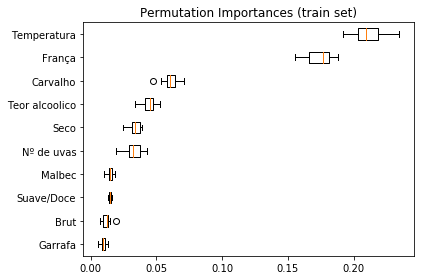

In [46]:
sorted_idx = result.importances_mean.argsort()
idx = sorted_idx[len(sorted_idx)-10:]

plt.figure(figsize=(6,4))
plt.boxplot(result.importances[idx].T,
           vert=False, labels=x_train.columns[idx])
plt.title("Permutation Importances (train set)")
plt.tight_layout()
plt.show()

### **Features importantes para o fitting na amostra de teste**

In [47]:
result = permutation_importance(model_rf, x_test, y_test, n_repeats=20, n_jobs=-1, random_state=0)

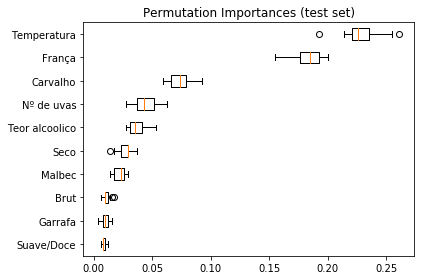

In [48]:
sorted_idx = result.importances_mean.argsort()
idx = sorted_idx[len(sorted_idx)-10:]

plt.figure(figsize=(6,4))
plt.boxplot(result.importances[idx].T,
           vert=False, labels=x_test.columns[idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()